In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
from src.pre_process.V4.feature_add import FeatureAddition
from src.pre_process.V4.feature_duplicate import FeatureDuplication

In [3]:
BASE_PATH = r'C:\Users\com\Documents\GitHub\level2-competitiveds-recsys-06\data\etc'
data = pd.read_csv('temp_real_v8.csv')
# train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
# test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

---

# data 확인

In [4]:
data

,index,_type,contract_year_month,contract_day,area_m2,contract_date_numeric,floor,built_year,latitude,longitude,...,nearest_park_distance,nearest_park_idx,park_grid_id,park_area,nearest_school_distance,nearest_school_idx,school_grid_id,nearest_subway_distance,nearest_subway_idx,subway_grid_id
0,0,train,201906,25,84.9981,20190625,9,2019,37.054314,127.045216,...,498.618918,9759,420.0,3898.0,156.120431,6739,521.0,716.952948,12,521.0
1,1,train,202003,26,84.9981,20200326,20,2019,37.054314,127.045216,...,498.618918,9759,420.0,3898.0,156.120431,6739,521.0,716.952948,12,521.0
2,2,train,202003,28,84.9981,20200328,8,2019,37.054314,127.045216,...,498.618918,9759,420.0,3898.0,156.120431,6739,521.0,716.952948,12,521.0
3,3,train,201907,15,59.3400,20190715,1,1986,36.964647,127.055847,...,169.839678,9139,121.0,1616.0,214.559689,6535,121.0,3897.279708,10,222.0
4,4,train,201904,12,59.8100,20190412,6,1995,36.972390,127.084514,...,382.401815,9201,122.0,3986.0,1708.489263,6589,222.0,2039.685349,10,222.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,test,202402,27,115.5101,20240227,17,2010,37.528394,126.659398,...,398.113485,14160,226.0,8963.9,224.754177,9387,226.0,1483.044562,293,227.0
1951396,150168,test,202403,2,142.8738,20240302,4,2010,37.528394,126.659398,...,398.113485,14160,226.0,8963.9,224.754177,9387,226.0,1483.044562,293,227.0
1951397,150169,test,202403,16,142.8738,20240316,13,2010,37.528394,126.659398,...,398.113485,14160,226.0,8963.9,224.754177,9387,226.0,1483.044562,293,227.0
1951398,150170,test,202403,22,114.9285,20240322,2,2010,37.528394,126.659398,...,398.113485,14160,226.0,8963.9,224.754177,9387,226.0,1483.044562,293,227.0


In [5]:
data.columns

Index(['index', '_type', 'contract_year_month', 'contract_day', 'area_m2',
       'contract_date_numeric', 'floor', 'built_year', 'latitude', 'longitude',
       'age', 'contract_0', 'contract_1', 'deposit', 'apt_idx', 'area',
       'grid_deposit', 'apt_deposit_rank', 'apt_area_deposit_rank',
       'recent_deposit', 'interest_rate', 'grid_id', 'nearest_park_distance',
       'nearest_park_idx', 'park_grid_id', 'park_area',
       'nearest_school_distance', 'nearest_school_idx', 'school_grid_id',
       'nearest_subway_distance', 'nearest_subway_idx', 'subway_grid_id'],
      dtype='object')

---

# 추가 EDA

In [6]:
# 각 grid_id마다 고유한 nearest_subway_idx의 개수를 계산
unique_subway_per_grid = data.groupby('grid_id')['nearest_subway_idx'].nunique().reset_index(name='unique_subway_count')

# 결과 확인
print(unique_subway_per_grid.max())

grid_id                4623
unique_subway_count      14
dtype: int64


In [7]:
# 각 grid_id에 있는 고유한 nearest_park_idx 개수 계산
unique_park_per_grid = data.groupby('park_grid_id')['nearest_park_idx'].nunique().reset_index(name='unique_park_count')

# 각 grid_id에 있는 고유한 nearest_school_idx 개수 계산
unique_school_per_grid = data.groupby('school_grid_id')['nearest_school_idx'].nunique().reset_index(name='unique_school_count')

# 결과 확인
print(unique_park_per_grid.head())
print(unique_school_per_grid.head())


   park_grid_id  unique_park_count
0          15.0                  1
1         113.0                  1
2         114.0                  2
3         116.0                  2
4         119.0                  1
   school_grid_id  unique_school_count
0            16.0                    1
1           109.0                    1
2           114.0                    1
3           116.0                    1
4           119.0                    1


In [8]:
# park_grid_id를 기준으로 unique_park_count 매핑
data['park_count'] = data['park_grid_id'].map(unique_park_per_grid.set_index('park_grid_id')['unique_park_count'])

# school_grid_id를 기준으로 unique_school_count 매핑
data['school_count'] = data['school_grid_id'].map(unique_school_per_grid.set_index('school_grid_id')['unique_school_count'])

# subway_grid_id를 기준으로 이미 계산한 unique_subway_count 매핑
data['subway_count'] = data['grid_id'].map(unique_subway_per_grid.set_index('grid_id')['unique_subway_count'])

# NaN 값을 0으로 대체
data[['park_count','school_count','subway_count']].fillna(0, inplace=True)

# 결과 확인
print(data[['park_grid_id', 'park_count', 'school_grid_id', 'school_count', 'grid_id', 'subway_count']].head())


   park_grid_id  park_count  school_grid_id  school_count  grid_id  \
0         420.0         9.0           521.0            15      520   
1         420.0         9.0           521.0            15      520   
2         420.0         9.0           521.0            15      520   
3         121.0         7.0           121.0             3      121   
4         122.0         1.0           222.0             6      222   

   subway_count  
0             1  
1             1  
2             1  
3             1  
4             1  


C:\Users\com\AppData\Local\Temp\ipykernel_17244\3367762499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['park_count','school_count','subway_count']].fillna(0, inplace=True)


In [9]:
# 데이터 길이 확인
data['date_length'] = data['contract_date_numeric'].astype(str).apply(len)
print(data['date_length'].value_counts())


date_length
8    1951400
Name: count, dtype: int64


In [10]:
import time
from datetime import datetime

data['contract_date'] = pd.to_datetime(data['contract_date_numeric'], format='%Y%m%d')

data['contract_timestamp'] = data['contract_date'].apply(lambda x: int(time.mktime(x.timetuple())))

print(data[['contract_date_numeric', 'contract_date', 'contract_timestamp']].head())


   contract_date_numeric contract_date  contract_timestamp
0               20190625    2019-06-25          1561388400
1               20200326    2020-03-26          1585148400
2               20200328    2020-03-28          1585321200
3               20190715    2019-07-15          1563116400
4               20190412    2019-04-12          1554994800


## 데이터 컬럼 확인

In [22]:
data.columns

Index(['index', '_type', 'contract_year_month', 'contract_day', 'area_m2',
       'contract_date_numeric', 'floor', 'built_year', 'latitude', 'longitude',
       'age', 'contract_0', 'contract_1', 'deposit', 'apt_idx', 'area',
       'grid_deposit', 'apt_deposit_rank', 'apt_area_deposit_rank',
       'recent_deposit', 'interest_rate', 'grid_id', 'nearest_park_distance',
       'nearest_park_idx', 'park_grid_id', 'park_area',
       'nearest_school_distance', 'nearest_school_idx', 'school_grid_id',
       'nearest_subway_distance', 'nearest_subway_idx', 'subway_grid_id',
       'park_count', 'school_count', 'subway_count', 'date_length',
       'contract_date', 'contract_timestamp'],
      dtype='object')

In [33]:
data.isnull().sum()

index                           0
_type                           0
contract_year_month             0
contract_day                    0
area_m2                         0
contract_date_numeric           0
floor                           0
built_year                      0
latitude                        0
longitude                       0
age                             0
contract_0                      0
contract_1                      0
deposit                    150172
apt_idx                         0
area                            0
grid_deposit                    0
apt_deposit_rank                0
apt_area_deposit_rank           0
recent_deposit              67857
interest_rate               11882
grid_id                         0
nearest_park_distance           0
nearest_park_idx                0
park_grid_id                   88
park_area                       0
nearest_school_distance         0
nearest_school_idx              0
school_grid_id                  0
nearest_subway

In [31]:
data.to_csv('v9.csv',index=False)

---

# 모델링

In [23]:
train_data = data[data['_type'] == 'train']
test_data = data[data['_type'] == 'test']

In [24]:
column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index','contract_year_month', 'contract_day', 'area_m2',
    'contract_date_numeric', 
    'area_m2',
    'floor', 'built_year', 'latitude', 'longitude','age', 
    'contract_0', 'contract_1', 
    'deposit', 
    'apt_idx', 
    'area',
    'grid_deposit', 
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit', 
    # 'interest_rate', 
    # 'grid_id',  'school_grid_id', 'park_grid_id', 'subway_grid_id',
    'nearest_park_distance','nearest_park_idx', 'park_area',
    'nearest_school_distance', 'nearest_school_idx',
    'nearest_subway_distance', 'nearest_subway_idx',
    'park_count', 'school_count', 'subway_count',
    # 'contract_timestamp',
]
test_column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index','contract_year_month', 'contract_day', 'area_m2',
    'contract_date_numeric',
    'area_m2',
    'floor', 'built_year', 'latitude', 'longitude','age', 
    'contract_0', 'contract_1',  
    'apt_idx', 
    'area',
    'grid_deposit', 
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit', 
    # 'interest_rate', 
    # 'grid_id',  'school_grid_id', 'park_grid_id', 'subway_grid_id',
    'nearest_park_distance','nearest_park_idx', 'park_area',
    'nearest_school_distance', 'nearest_school_idx',
    'nearest_subway_distance', 'nearest_subway_idx',
    'park_count', 'school_count', 'subway_count',
    # 'contract_timestamp',
]
train_df = train_data[column_needed]
test_df = test_data[test_column_needed]

In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# # 학습에 사용할 특징 열
# feature_columns = [col for col in data.columns if col not in ['deposit', '_type', 'index']]
# 학습 및 테스트 데이터 준비
X_train = train_df.drop(columns=['deposit'])
y_train = train_df['deposit']
X_test = test_df.copy()
# 학습 데이터를 검증용으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2,
                                                                          random_state=42)
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val_split, label=y_val_split)
dtest = xgb.DMatrix(X_test)
# XGBoost 파라미터 설정
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
# 모델 학습
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=50, evals=evals, verbose_eval=10)
# 테스트 세트에 대한 예측
y_pred = model.predict(dtest)

[0]	train-mae:16477.66290	eval-mae:16479.61304
[10]	train-mae:11229.43805	eval-mae:11231.48890
[20]	train-mae:8060.68567	eval-mae:8057.84171
[30]	train-mae:6261.85207	eval-mae:6252.50556
[40]	train-mae:5307.64348	eval-mae:5295.50616
[50]	train-mae:4785.07519	eval-mae:4773.57622
[60]	train-mae:4513.12787	eval-mae:4504.25448
[70]	train-mae:4371.29475	eval-mae:4364.46552
[80]	train-mae:4281.42614	eval-mae:4276.90155
[90]	train-mae:4234.73839	eval-mae:4230.86734
[100]	train-mae:4201.21827	eval-mae:4198.05642
[110]	train-mae:4172.24428	eval-mae:4169.92489
[120]	train-mae:4149.84370	eval-mae:4148.53670
[130]	train-mae:4127.21964	eval-mae:4126.88941
[140]	train-mae:4108.38547	eval-mae:4108.92510
[150]	train-mae:4088.04908	eval-mae:4089.40359
[160]	train-mae:4074.50690	eval-mae:4076.39115
[170]	train-mae:4062.66001	eval-mae:4065.31382
[180]	train-mae:4050.56977	eval-mae:4053.93720
[190]	train-mae:4042.48937	eval-mae:4046.31472
[200]	train-mae:4029.29052	eval-mae:4033.67618
[210]	train-mae:4022

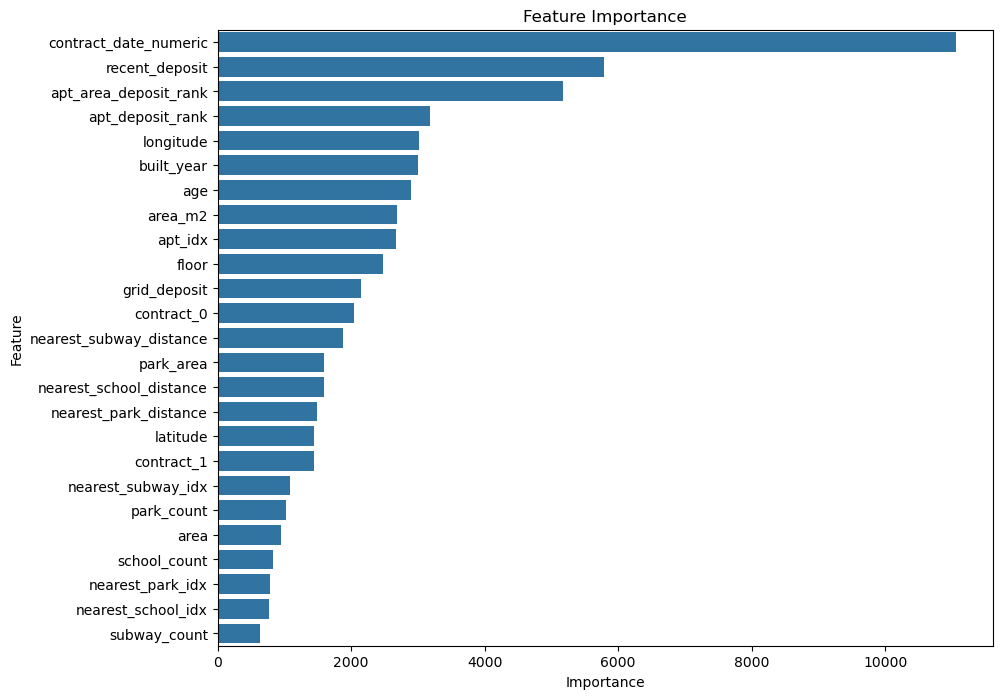

In [26]:
#Feature Importance
# 피처 중요도 추출
feature_importance = model.get_fscore()
# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [27]:
y_pred

array([22802.139 ,  7256.283 ,  6384.8555, ..., 45519.47  , 37123.64  ,
       38261.547 ], dtype=float32)

In [28]:
sample_submission['deposit'] = y_pred
sample_submission

,index,deposit
0,0,22802.138672
1,1,7256.283203
2,2,6384.855469
3,3,6549.868164
4,4,6749.155273
...,...,...
150167,150167,37280.503906
150168,150168,43815.035156
150169,150169,45519.468750
150170,150170,37123.640625


In [29]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,39195.167969
std,43351.06665,24097.947266
min,0.00000,3206.022217
25%,37542.75000,23223.801270
50%,75085.50000,33982.140625
75%,112628.25000,48647.042969
max,150171.00000,414229.250000


In [30]:
sample_submission.to_csv('v8_xgb_1000.csv', index=False)

---